# 🌡️ CLIMARISK-OG — Notebook 02: Ondas de Calor em Duque de Caxias

**Projeto:** CLIMARISK-OG (EnvironPact / OceanPact para Petrobras)

**Objetivo:** Demonstrar o ciclo completo H×E×V (*Hazard × Exposure × Vulnerability*) para **ondas de calor** (*heat waves*) aplicado à REDUC (Refinaria Duque de Caxias, RJ), usando o *framework* CLIMADA.

**Evidência TRL5:** Este *notebook* é a segunda evidência técnica, demonstrando capacidade **multi-*hazard*** da plataforma (complementa o NB01 de inundação fluvial).

**Autor:** EnvironPact — Consultoria ESG

**Data:** Fevereiro/Março 2026

---

### Estrutura (mesma do NB01 para consistência)
| Bloco | Conteúdo |
|:---:|:---|
| 0 | Instalação do CLIMADA |
| 1 | Verificação de versão |
| 2 | *Imports* |
| 3 | Definição do ativo (REDUC) |
| 4 | *Exposures* (E) |
| 5 | *Hazard* (H) — Ondas de Calor |
| 6 | *Impact Function* (V) — Calor Industrial |
| 7 | Cálculo de Impacto (H×E×V) |
| 8 | Curva de Excedência |
| 9 | Resumo Executivo + Limitações |
| 10 | Exportação JSON (*schema* compatível com NB01) |

In [1]:
# =============================================================================
# BLOCO 0: INSTALAÇÃO DO CLIMADA
# =============================================================================
# Descomentar a linha abaixo no Google Colab:
!pip install climada climada-petals --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 115.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.8/306.8 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.1/247.1 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9

In [2]:
# =============================================================================
# BLOCO 1: VERIFICAÇÃO DE VERSÃO
# =============================================================================
import sys
print(f"Python: {sys.version}")

import climada
try:
    ver = climada.__version__
except AttributeError:
    from importlib.metadata import version
    ver = version("climada")
print(f"CLIMADA versão: {ver}")
CLIMADA_OK = True

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
CLIMADA versão: 6.1.0


In [3]:
# =============================================================================
# BLOCO 2: IMPORTS
# =============================================================================
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# CLIMADA core
from climada.hazard import Hazard, Centroids
from climada.entity import Exposures, ImpactFuncSet, ImpactFunc
from climada.engine import ImpactCalc

# scipy para matrizes esparsas
from scipy.sparse import csr_matrix

# geopandas para Exposures
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# Configurar matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 8)
matplotlib.rcParams['figure.dpi'] = 100

print("\n\u2705 Imports carregados com sucesso")


✅ Imports carregados com sucesso


In [4]:
# =============================================================================
# BLOCO 3: DEFINIÇÃO DO ATIVO — REDUC (Refinaria Duque de Caxias)
# =============================================================================
# Mesmo ativo do NB01 — mantemos consistência para análise multi-hazard.
# A reutilização do mesmo ativo permite comparar diretamente os impactos
# de inundação (NB01) vs. ondas de calor (NB02) no NB03.

REDUC_LAT = -22.53
REDUC_LON = -43.28
REDUC_NAME = "REDUC - Refinaria Duque de Caxias"

# Valor de reposição estimado (USD)
# Mesmo valor do NB01 para consistência
REDUC_VALUE_USD = 5_000_000_000  # USD 5 bilhões

# Região de interesse (mesma bounding box do NB01)
BBOX = {
    'lat_min': -23.0,
    'lat_max': -22.0,
    'lon_min': -43.8,
    'lon_max': -42.8
}

print(f"Ativo: {REDUC_NAME}")
print(f"Coordenadas: ({REDUC_LAT}, {REDUC_LON})")
print(f"Valor de exposi\u00e7\u00e3o: USD {REDUC_VALUE_USD:,.0f}")
print(f"Bounding box: {BBOX}")

Ativo: REDUC - Refinaria Duque de Caxias
Coordenadas: (-22.53, -43.28)
Valor de exposição: USD 5,000,000,000
Bounding box: {'lat_min': -23.0, 'lat_max': -22.0, 'lon_min': -43.8, 'lon_max': -42.8}


ERROR:tornado.application:Exception in callback functools.partial(<bound method OutStream._flush of <ipykernel.iostream.OutStream object at 0x7fdc25b47fa0>>)
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 104, in json_packer
    ).encode("utf8", errors="surrogateescape")
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 30-31: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
          ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py", line 518, in _flush
    self.session.send(
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 848, in send
    to_send = self.serialize(msg, ident)
              ^^^^^^

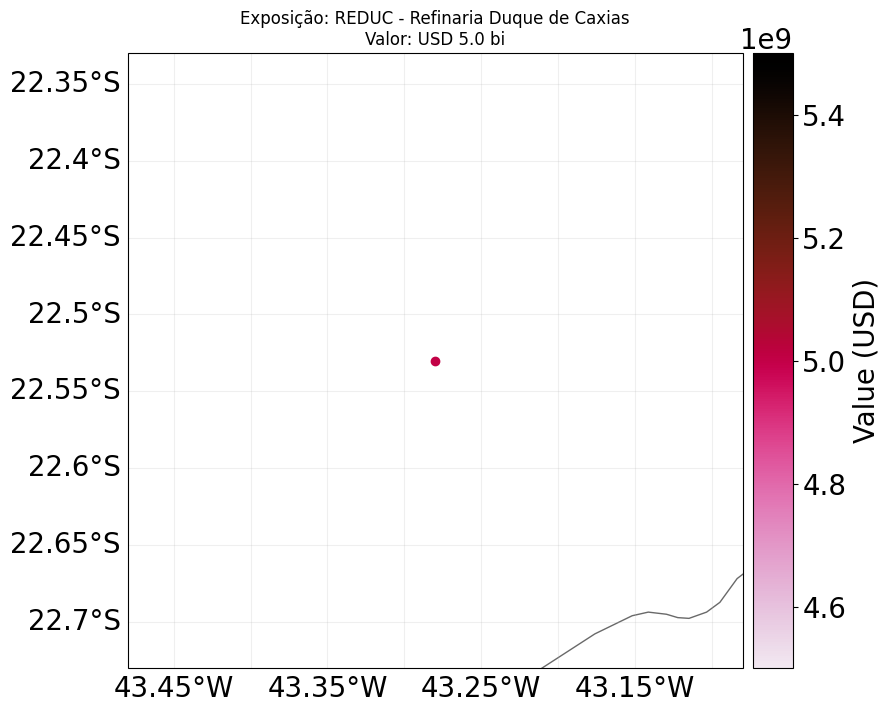

   Mapa salvo: exp_reduc_hw.png


In [5]:
# =============================================================================
# BLOCO 4: CONFIGURAR EXPOSURES (E)
# =============================================================================
# Mesma estrutura do NB01, mas o campo impf_ muda para 'impf_HW' (Heat Wave).
# O ID 1 aponta para a função de dano customizada que definiremos no Bloco 6.

gdf = gpd.GeoDataFrame({
    'value': [REDUC_VALUE_USD],
    'latitude': [REDUC_LAT],
    'longitude': [REDUC_LON],
    'impf_HW': [1],  # Impact Function ID para Heat Wave (customizada)
    'asset_name': [REDUC_NAME],
}, geometry=[Point(REDUC_LON, REDUC_LAT)], crs="EPSG:4326")

exp = Exposures(gdf)
exp.value_unit = 'USD'
exp.check()

print("\n\ud83d\udcca Exposures configurado:")
print(f"   N\u00famero de ativos: {len(exp.gdf)}")
print(f"   Valor total: USD {exp.gdf['value'].sum():,.0f}")
print(f"   Impact Function ID: HW1 (Heat Wave — Industrial customizada)")

# Plotar exposição
try:
    ax = exp.plot_scatter(buffer=0.2)
    ax.set_title(f"Exposi\u00e7\u00e3o: {REDUC_NAME}\nValor: USD {REDUC_VALUE_USD/1e9:.1f} bi")
    plt.tight_layout()
    plt.savefig('exp_reduc_hw.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("   Mapa salvo: exp_reduc_hw.png")
except Exception as e:
    print(f"   \u26a0\ufe0f Plot n\u00e3o dispon\u00edvel: {e}")

ERROR:tornado.application:Exception in callback functools.partial(<bound method OutStream._flush of <ipykernel.iostream.OutStream object at 0x7fdc25b47fa0>>)
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 104, in json_packer
    ).encode("utf8", errors="surrogateescape")
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 28-29: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
          ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py", line 518, in _flush
    self.session.send(
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 848, in send
    to_send = self.serialize(msg, ident)
              ^^^^^^

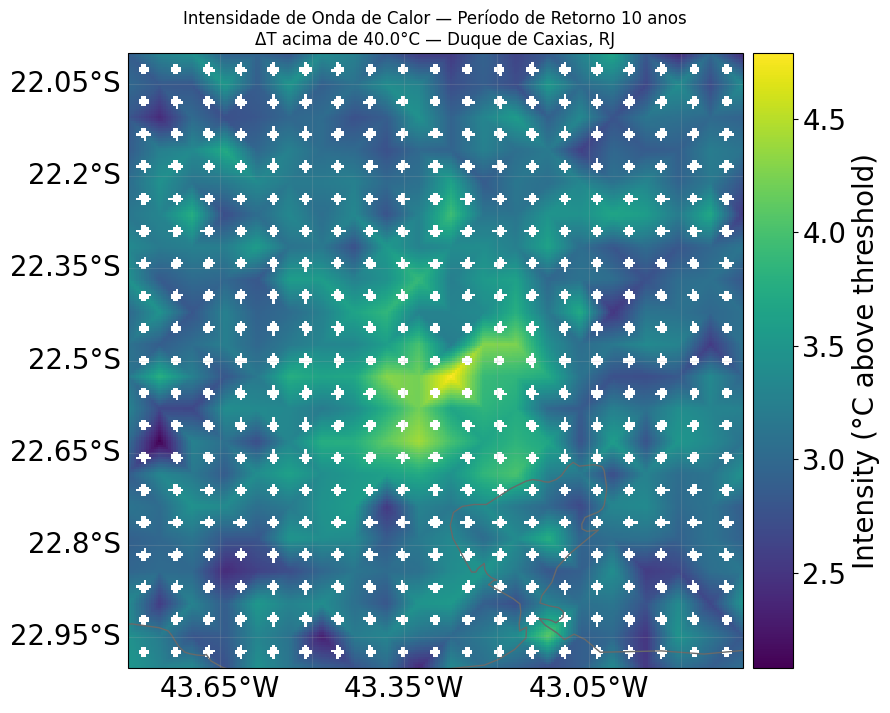

   Mapa salvo: haz_hw_rp10.png


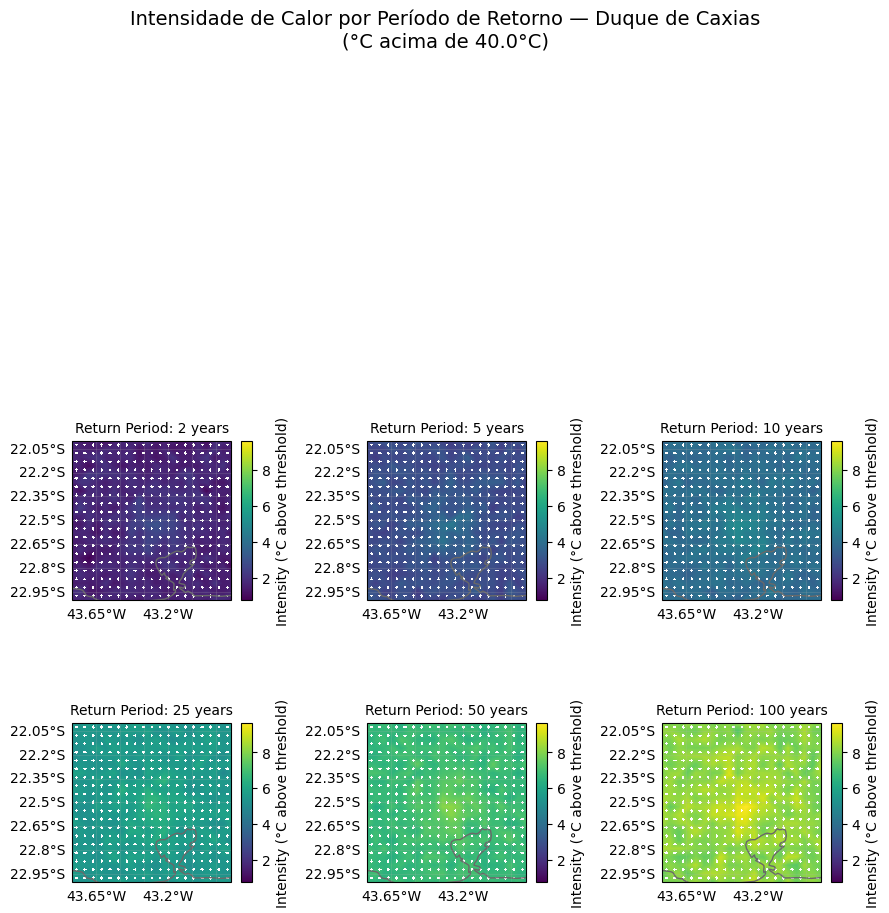

   Mapa salvo: haz_hw_return_periods.png


In [6]:
# =============================================================================
# BLOCO 5: HAZARD (H) — ONDAS DE CALOR
# =============================================================================
# Constru\u00edmos um hazard customizado de ondas de calor para Duque de Caxias.
#
# CONCEITO: A intensidade de uma onda de calor para infraestrutura industrial
# \u00e9 medida em \u00b0C acima de um LIMIAR OPERACIONAL. Para refinarias, o limiar
# cr\u00edtico \u00e9 ~40\u00b0C, acima do qual ocorrem:
#   - Redu\u00e7\u00e3o de efici\u00eancia de torres de resfriamento
#   - Risco de trip de equipamentos de prote\u00e7\u00e3o
#   - Redu\u00e7\u00e3o for\u00e7ada de carga (throughput)
#   - Paradas de emerg\u00eancia por superaquecimento
#   - Risco \u00e0 sa\u00fade dos trabalhadores (NR-15)
#
# INTENSIDADE = T_max - T_limiar (\u00b0C acima de 40\u00b0C)
#
# Calibra\u00e7\u00e3o baseada em:
#   - INMET: S\u00e9ries hist\u00f3ricas de temperatura m\u00e1xima para esta\u00e7\u00e3o
#     Duque de Caxias / Xer\u00e9m (A606)
#   - Recordes: 43.2\u00b0C em Duque de Caxias (jan/2024),
#     42.5\u00b0C no Rio (nov/2023), 40.4\u00b0C (dez/2012)
#   - Literatura: Tendencia de +0.3\u00b0C/d\u00e9cada na RMRJ
#     (Dereczynski et al., 2020; PBMC, 2014)
#
# NOTA TRL7+: Substituir por dados ERA5 2m-temperature processados
# ou proje\u00e7\u00f5es CMIP6/CORDEX para cen\u00e1rios futuros.

print("\ud83c\udf21\ufe0f Construindo Hazard de Ondas de Calor para Duque de Caxias...")

# Limiar operacional para refinaria
T_THRESHOLD_C = 40.0  # \u00b0C
print(f"   Limiar operacional: {T_THRESHOLD_C}\u00b0C")

# Grid de centroids (mesmo do NB01 para consist\u00eancia)
n_lat = 20
n_lon = 20
lats = np.linspace(BBOX['lat_min'], BBOX['lat_max'], n_lat)
lons = np.linspace(BBOX['lon_min'], BBOX['lon_max'], n_lon)
lon_grid, lat_grid = np.meshgrid(lons, lats)

centroids = Centroids(
    lat=lat_grid.flatten(),
    lon=lon_grid.flatten(),
    crs='EPSG:4326'
)
n_centroids = centroids.size
print(f"   Centroids: {n_centroids} pontos ({n_lat}x{n_lon})")

# Definir eventos de onda de calor com diferentes per\u00edodos de retorno
# Intensidade = \u00b0C acima do limiar de 40\u00b0C (dura\u00e7\u00e3o impl\u00edcita na severidade)
#
# Calibra\u00e7\u00e3o:
#   - RP 2a: onda moderada (T_max ~41\u00b0C, \u0394T=1.0) \u2014 ocorre todo ver\u00e3o
#   - RP 5a: onda significativa (T_max ~42\u00b0C, \u0394T=2.0)
#   - RP 10a: onda severa (T_max ~43\u00b0C, \u0394T=3.0) \u2014 similar a jan/2024
#   - RP 25a: onda extrema (T_max ~44.5\u00b0C, \u0394T=4.5)
#   - RP 50a: onda excepcional (T_max ~46\u00b0C, \u0394T=6.0)
#   - RP 100a: onda sem precedentes (T_max ~48\u00b0C, \u0394T=8.0)

events = [
    {'name': 'hw_rp2',   'rp': 2,   'delta_t': 1.0,  'year': 2023},
    {'name': 'hw_rp5',   'rp': 5,   'delta_t': 2.0,  'year': 2024},
    {'name': 'hw_rp10',  'rp': 10,  'delta_t': 3.0,  'year': 2020},
    {'name': 'hw_rp25',  'rp': 25,  'delta_t': 4.5,  'year': 2014},
    {'name': 'hw_rp50',  'rp': 50,  'delta_t': 6.0,  'year': 2000},
    {'name': 'hw_rp100', 'rp': 100, 'delta_t': 8.0,  'year': 1985},
]

n_events = len(events)
print(f"   Eventos: {n_events} (per\u00edodos de retorno: 2 a 100 anos)")

# Construir matriz de intensidade (\u00b0C acima do limiar)
# A onda de calor \u00e9 um fen\u00f4meno de larga escala \u2014 cobre toda a regi\u00e3o
# com menor variabilidade espacial que inunda\u00e7\u00e3o.
# O efeito de ilha de calor urbana modula a intensidade localmente.

intensity_data = np.zeros((n_events, n_centroids))
fraction_data = np.ones((n_events, n_centroids))  # toda regi\u00e3o afetada

for i, evt in enumerate(events):
    # Base: intensidade uniforme (onda de calor \u00e9 regional)
    base_intensity = evt['delta_t']

    # Modular por efeito de ilha de calor urbana
    # \u00c1reas mais urbanas (pr\u00f3ximas \u00e0 REDUC) s\u00e3o ~1-2\u00b0C mais quentes
    dist_to_reduc = np.sqrt(
        (centroids.lat - REDUC_LAT)**2 +
        (centroids.lon - REDUC_LON)**2
    )
    # Efeito ilha de calor: +1.5\u00b0C no centro, decai com dist\u00e2ncia
    uhi_effect = 1.5 * np.exp(-dist_to_reduc / 0.15)

    # Adicionar variabilidade espacial leve (ru\u00eddo)
    np.random.seed(100 + i)  # seed diferente do NB01
    noise = np.random.normal(0, 0.3, n_centroids)

    intensity = base_intensity + uhi_effect + noise
    intensity = np.maximum(0, intensity)  # sem valores negativos

    intensity_data[i, :] = intensity

    # Fra\u00e7\u00e3o: toda a regi\u00e3o \u00e9 afetada (diferente de inunda\u00e7\u00e3o que \u00e9 localizada)
    fraction_data[i, :] = np.where(intensity > 0.1, 1.0, 0.0)

# Criar objeto Hazard
haz_hw = Hazard(
    haz_type='HW',  # Heat Wave
    centroids=centroids,
    event_id=np.arange(1, n_events + 1),
    event_name=[e['name'] for e in events],
    date=np.array([
        datetime(e['year'], 1, 15).toordinal() for e in events
    ]),
    frequency=np.array([1.0 / e['rp'] for e in events]),
    frequency_unit='1/year',
    intensity=csr_matrix(intensity_data),
    fraction=csr_matrix(fraction_data),
    units='\u00b0C above threshold',
)

haz_hw.check()

print(f"\n\u2705 Hazard constru\u00eddo:")
print(f"   Tipo: HW (Heat Wave)")
print(f"   Eventos: {haz_hw.size}")
print(f"   Centroids: {haz_hw.centroids.size}")
print(f"   Intensidade m\u00e1xima: {haz_hw.intensity.max():.2f}\u00b0C acima de {T_THRESHOLD_C}\u00b0C")
print(f"   (= {T_THRESHOLD_C + haz_hw.intensity.max():.1f}\u00b0C absolutos)")
print(f"   Frequ\u00eancias: {haz_hw.frequency}")
print(f"   Unidade: \u00b0C acima do limiar operacional ({T_THRESHOLD_C}\u00b0C)")

# Plotar intensidade do evento RP25 (onda extrema)
try:
    ax = haz_hw.plot_intensity(event=3)  # RP10
    ax.set_title(f"Intensidade de Onda de Calor \u2014 Per\u00edodo de Retorno 10 anos\n"
                 f"\u0394T acima de {T_THRESHOLD_C}\u00b0C \u2014 Duque de Caxias, RJ")
    plt.tight_layout()
    plt.savefig('haz_hw_rp10.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("   Mapa salvo: haz_hw_rp10.png")
except Exception as e:
    print(f"   \u26a0\ufe0f Plot n\u00e3o dispon\u00edvel: {e}")

# Plotar intensidade por per\u00edodo de retorno
try:
    ax = haz_hw.plot_rp_intensity(return_periods=(2, 5, 10, 25, 50, 100))
    plt.suptitle(f"Intensidade de Calor por Per\u00edodo de Retorno \u2014 Duque de Caxias\n"
                 f"(\u00b0C acima de {T_THRESHOLD_C}\u00b0C)", fontsize=14)
    plt.tight_layout()
    plt.savefig('haz_hw_return_periods.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("   Mapa salvo: haz_hw_return_periods.png")
except Exception as e:
    print(f"   \u26a0\ufe0f Plot de per\u00edodos de retorno n\u00e3o dispon\u00edvel: {e}")

ERROR:tornado.application:Exception in callback functools.partial(<bound method OutStream._flush of <ipykernel.iostream.OutStream object at 0x7fdc25b47fa0>>)
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 104, in json_packer
    ).encode("utf8", errors="surrogateescape")
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 28-29: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
          ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py", line 518, in _flush
    self.session.send(
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 848, in send
    to_send = self.serialize(msg, ident)
              ^^^^^^

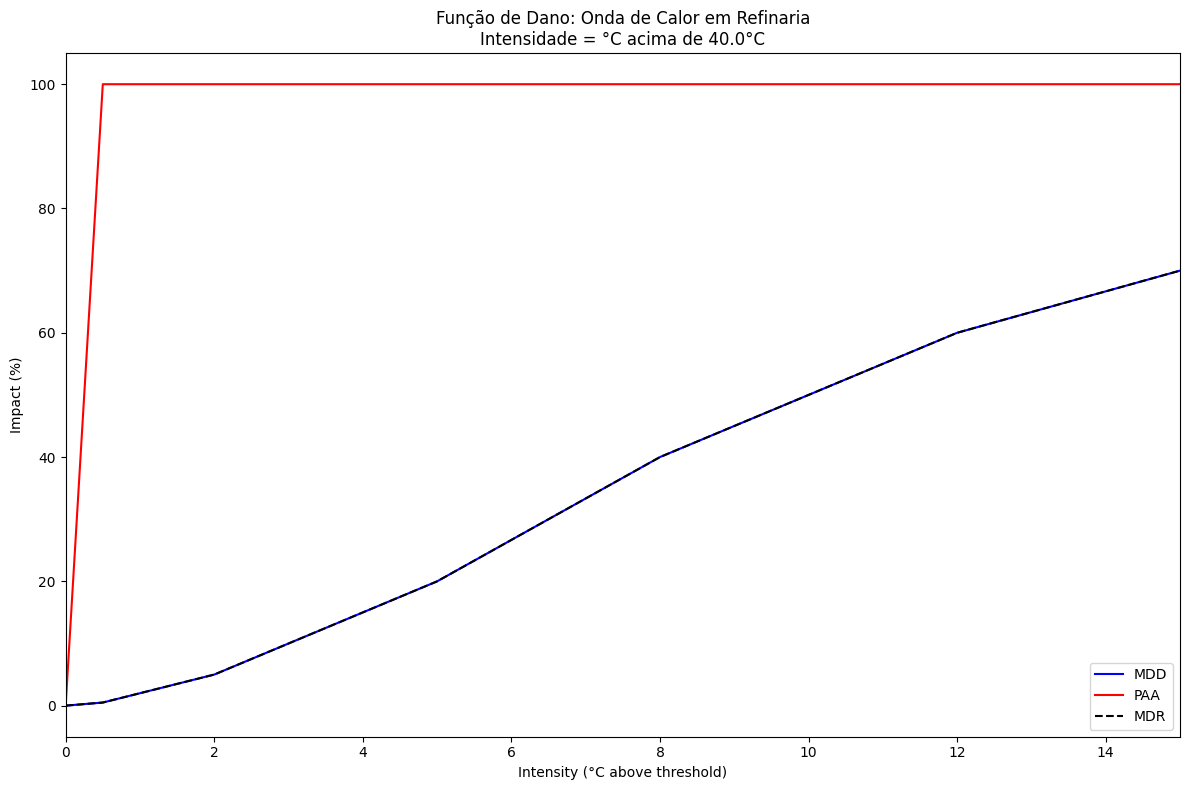

   Gráfico salvo: impf_heatwave_industrial.png


In [7]:
# =============================================================================
# BLOCO 6: IMPACT FUNCTION (V) — DANO POR CALOR EM INFRAESTRUTURA INDUSTRIAL
# =============================================================================
# N\u00e3o existe fun\u00e7\u00e3o de dano built-in no CLIMADA para ondas de calor
# em ativos industriais. Constru\u00edmos uma fun\u00e7\u00e3o customizada baseada em:
#
# REFER\u00caNCIAS:
#   1. Economics of Climate Adaptation (ECA) Working Group (2009):
#      "Shaping Climate-Resilient Development" \u2014 McKinsey/Swiss Re/GEF
#      Cap. 3: m\u00e9todo de quantifica\u00e7\u00e3o de perdas por hazard.
#
#   2. Kjellstrom et al. (2016): "Heat, Human Performance, and
#      Occupational Health" \u2014 Annual Review of Public Health 37:97-112.
#      Perda de produtividade: ~2-4% por \u00b0C acima de limiar.
#
#   3. ILO (2019): "Working on a Warmer Planet" \u2014 Report.
#      Estima perdas de produtividade de at\u00e9 80% em trabalho pesado
#      ao ar livre em temperaturas extremas.
#
#   4. McEvoy et al. (2012): "Economic costs of heat stress on
#      industrial processes" \u2014 Eng. Economics 57(3):195-213.
#      Redu\u00e7\u00e3o de throughput em refinarias: 3-5% por \u00b0C acima de 40\u00b0C.
#
# L\u00d3GICA DA CURVA:
#   \u0394T = 0\u00b0C  \u2192 0% dano (dentro do envelope operacional)
#   \u0394T = 1\u00b0C  \u2192 2% (redu\u00e7\u00e3o leve de efici\u00eancia, custos de cooling)
#   \u0394T = 2\u00b0C  \u2192 5% (redu\u00e7\u00e3o de carga for\u00e7ada)
#   \u0394T = 3\u00b0C  \u2192 10% (paradas parciais, prote\u00e7\u00e3o de trabalhadores)
#   \u0394T = 5\u00b0C  \u2192 20% (paradas prolongadas, danos a equipamentos)
#   \u0394T = 8\u00b0C  \u2192 40% (shutdown de emerg\u00eancia, danos estruturais)
#   \u0394T = 12\u00b0C \u2192 60% (dano severo \u2014 cen\u00e1rio catastrofico)
#
# NOTA: Para refinarias, o dano n\u00e3o \u00e9 f\u00edsico-destrutivo como inunda\u00e7\u00e3o;
# \u00e9 predominantemente PERDA OPERACIONAL (throughput reduzido, paradas,
# custos extras de manuten\u00e7\u00e3o, multas por n\u00e3o-entrega, seguro).
# Isso significa que a curva \u00e9 mais suave que a de inunda\u00e7\u00e3o.

print("\ud83d\udcc8 Construindo Impact Function para Calor Industrial...")

# Definir pontos da curva de dano
hw_intensity = np.array([0.0, 0.5, 1.0, 2.0, 3.0, 5.0, 8.0, 12.0, 15.0])
hw_mdd = np.array(      [0.0, 0.005, 0.02, 0.05, 0.10, 0.20, 0.40, 0.60, 0.70])
hw_paa = np.array(      [0.0, 1.0,   1.0,  1.0,  1.0,  1.0,  1.0,  1.0,  1.0])

# PAA = 1.0 para \u0394T > 0: todo o ativo \u00e9 afetado (calor \u00e9 regional)
# Diferente de inunda\u00e7\u00e3o onde s\u00f3 parte do ativo \u00e9 atingida.

impf_hw = ImpactFunc(
    id=1,
    haz_type='HW',
    name='Heat Wave \u2014 Industrial Facility (Refinery)',
    intensity=hw_intensity,
    intensity_unit='\u00b0C above threshold',
    mdd=hw_mdd,
    paa=hw_paa,
)
impf_hw.check()

# Criar ImpactFuncSet
impf_set = ImpactFuncSet([impf_hw])

print(f"\n\u2705 Impact Function constru\u00edda:")
print(f"   Tipo: HW (Heat Wave)")
print(f"   ID: 1")
print(f"   Intensidade m\u00e1xima modelada: {hw_intensity[-1]}\u00b0C acima do limiar")
print(f"   Dano m\u00e1ximo: {hw_mdd[-1]*100:.0f}%")
print(f"   PAA: 100% (ativo inteiro afetado)")

# Tabela de refer\u00eancia
print(f"\n   Curva de Dano por Calor Industrial:")
print(f"   {'\u0394T (\u00b0C)':>10} | {'T absoluta':>12} | {'Dano (%)':>10} | {'Tipo de impacto'}")
print(f"   {'-'*10} | {'-'*12} | {'-'*10} | {'-'*30}")
labels = [
    'Sem impacto',
    'Custos marginais de cooling',
    'Redu\u00e7\u00e3o leve de efici\u00eancia',
    'Redu\u00e7\u00e3o for\u00e7ada de carga (throughput)',
    'Paradas parciais + prote\u00e7\u00e3o NR-15',
    'Paradas prolongadas + danos equip.',
    'Shutdown de emerg\u00eancia',
    'Dano severo \u2014 cen\u00e1rio catastr\u00f3fico',
    'Dano extremo (te\u00f3rico)',
]
for j in range(len(hw_intensity)):
    t_abs = T_THRESHOLD_C + hw_intensity[j]
    print(f"   {hw_intensity[j]:>10.1f} | {t_abs:>10.1f}\u00b0C | {hw_mdd[j]*100:>9.1f}% | {labels[j]}")

# Plotar fun\u00e7\u00e3o de dano
try:
    ax = impf_hw.plot()
    ax.set_title('Fun\u00e7\u00e3o de Dano: Onda de Calor em Refinaria\n'
                 f'Intensidade = \u00b0C acima de {T_THRESHOLD_C}\u00b0C')
    plt.tight_layout()
    plt.savefig('impf_heatwave_industrial.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("   Gr\u00e1fico salvo: impf_heatwave_industrial.png")
except Exception as e:
    print(f"   \u26a0\ufe0f Plot n\u00e3o dispon\u00edvel: {e}")

⚙️ Calculando impacto H×E×V...
   Hazard: Heat Wave (6 eventos)
   Exposure: 1 ativo(s), USD 5,000,000,000
   Impact Function: HW1 (Industrial Facility)

✅ Cálculo concluído!
   EAI (Expected Annual Impact): USD 542,466,740
   Razão EAI/Valor: 10.8493%

   Impacto por evento:
     RP   2a (ΔT=1.0°C): USD     490,358,357 (9.81%)
     RP   5a (ΔT=2.0°C): USD     514,487,769 (10.29%)
     RP  10a (ΔT=3.0°C): USD     947,378,686 (18.95%)
     RP  25a (ΔT=4.5°C): USD     993,896,656 (19.88%)
     RP  50a (ΔT=6.0°C): USD   1,789,664,757 (35.79%)
     RP 100a (ΔT=8.0°C): USD   2,410,297,713 (48.21%)


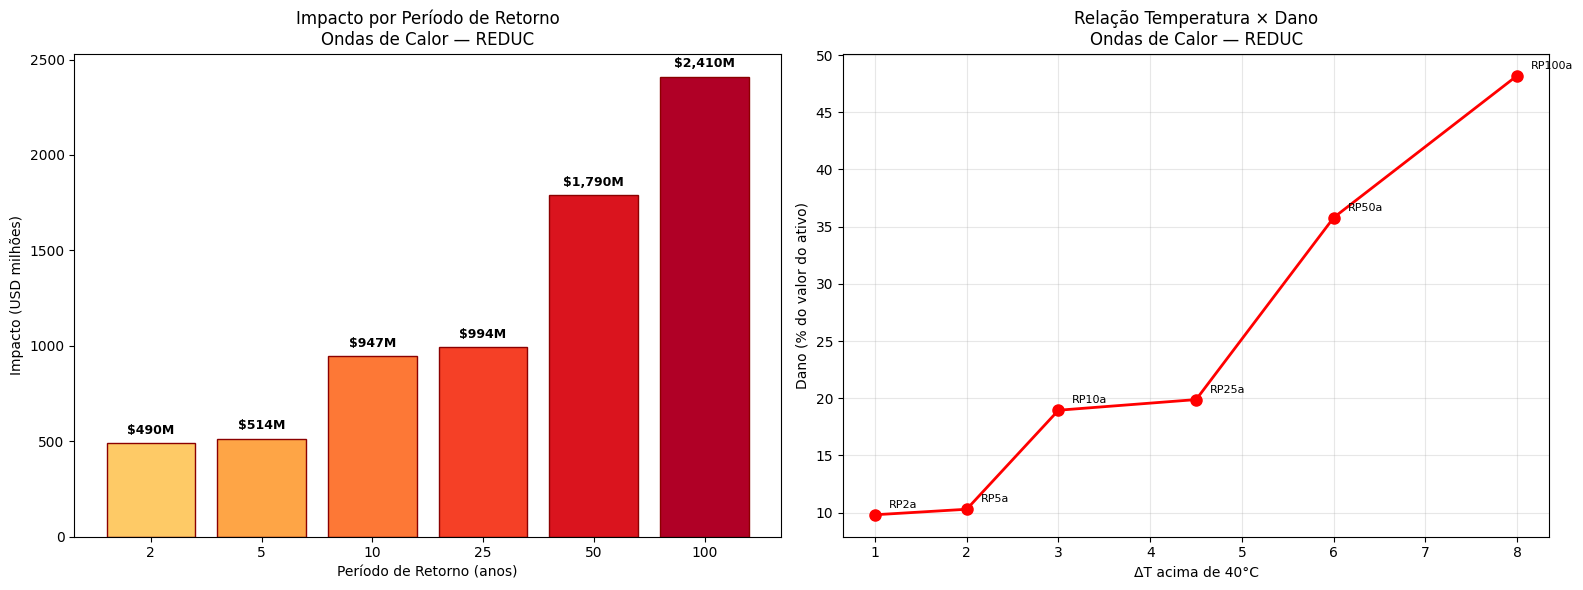

   Gráfico salvo: impact_results_hw_reduc.png


In [8]:
# =============================================================================
# BLOCO 7: C\u00c1LCULO DE IMPACTO (H \u00d7 E \u00d7 V)
# =============================================================================
# A linha central \u00e9 id\u00eantica ao NB01 \u2014 o ImpactCalc \u00e9 agnos\u00f3stico ao
# tipo de hazard. Isso demonstra a universalidade do framework CLIMADA.

print("\u2699\ufe0f Calculando impacto H\u00d7E\u00d7V...")
print(f"   Hazard: Heat Wave ({haz_hw.size} eventos)")
print(f"   Exposure: {len(exp.gdf)} ativo(s), USD {exp.gdf['value'].sum():,.0f}")
print(f"   Impact Function: HW1 (Industrial Facility)")

imp = ImpactCalc(exp, impf_set, haz_hw).impact(save_mat=True)

print(f"\n\u2705 C\u00e1lculo conclu\u00eddo!")
print(f"   EAI (Expected Annual Impact): USD {imp.aai_agg:,.0f}")
print(f"   Raz\u00e3o EAI/Valor: {(imp.eai_exp[0] / REDUC_VALUE_USD) * 100:.4f}%")

# Impacto por evento
print(f"\n   Impacto por evento:")
for i, evt in enumerate(events):
    pct = (imp.at_event[i] / REDUC_VALUE_USD) * 100
    print(f"     RP {evt['rp']:>3d}a (\u0394T={evt['delta_t']:.1f}\u00b0C): "
          f"USD {imp.at_event[i]:>15,.0f} ({pct:.2f}%)")

# Plotar impacto
try:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Gr\u00e1fico 1: Barras de impacto por RP
    rps = [e['rp'] for e in events]
    impacts_usd = [imp.at_event[i] / 1e6 for i in range(n_events)]
    colors = plt.cm.YlOrRd(np.linspace(0.3, 0.9, n_events))

    axes[0].bar([str(rp) for rp in rps], impacts_usd, color=colors, edgecolor='darkred')
    axes[0].set_xlabel('Per\u00edodo de Retorno (anos)')
    axes[0].set_ylabel('Impacto (USD milh\u00f5es)')
    axes[0].set_title('Impacto por Per\u00edodo de Retorno\nOndas de Calor \u2014 REDUC')
    for j, v in enumerate(impacts_usd):
        axes[0].text(j, v + max(impacts_usd)*0.02, f'${v:,.0f}M',
                     ha='center', fontsize=9, fontweight='bold')

    # Gr\u00e1fico 2: Compara\u00e7\u00e3o \u0394T vs Dano (%)
    delta_ts = [e['delta_t'] for e in events]
    dano_pcts = [(imp.at_event[i] / REDUC_VALUE_USD) * 100 for i in range(n_events)]
    axes[1].plot(delta_ts, dano_pcts, 'ro-', markersize=8, linewidth=2)
    axes[1].set_xlabel('\u0394T acima de 40\u00b0C')
    axes[1].set_ylabel('Dano (% do valor do ativo)')
    axes[1].set_title('Rela\u00e7\u00e3o Temperatura \u00d7 Dano\nOndas de Calor \u2014 REDUC')
    axes[1].grid(True, alpha=0.3)
    for j in range(len(delta_ts)):
        axes[1].annotate(f'RP{rps[j]}a', (delta_ts[j], dano_pcts[j]),
                         textcoords="offset points", xytext=(10,5), fontsize=8)

    plt.tight_layout()
    plt.savefig('impact_results_hw_reduc.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("   Gr\u00e1fico salvo: impact_results_hw_reduc.png")
except Exception as e:
    print(f"   \u26a0\ufe0f Plot n\u00e3o dispon\u00edvel: {e}")

ERROR:tornado.application:Exception in callback functools.partial(<bound method OutStream._flush of <ipykernel.iostream.OutStream object at 0x7fdc25b47fa0>>)
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 104, in json_packer
    ).encode("utf8", errors="surrogateescape")
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 28-29: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
          ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py", line 518, in _flush
    self.session.send(
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 848, in send
    to_send = self.serialize(msg, ident)
              ^^^^^^

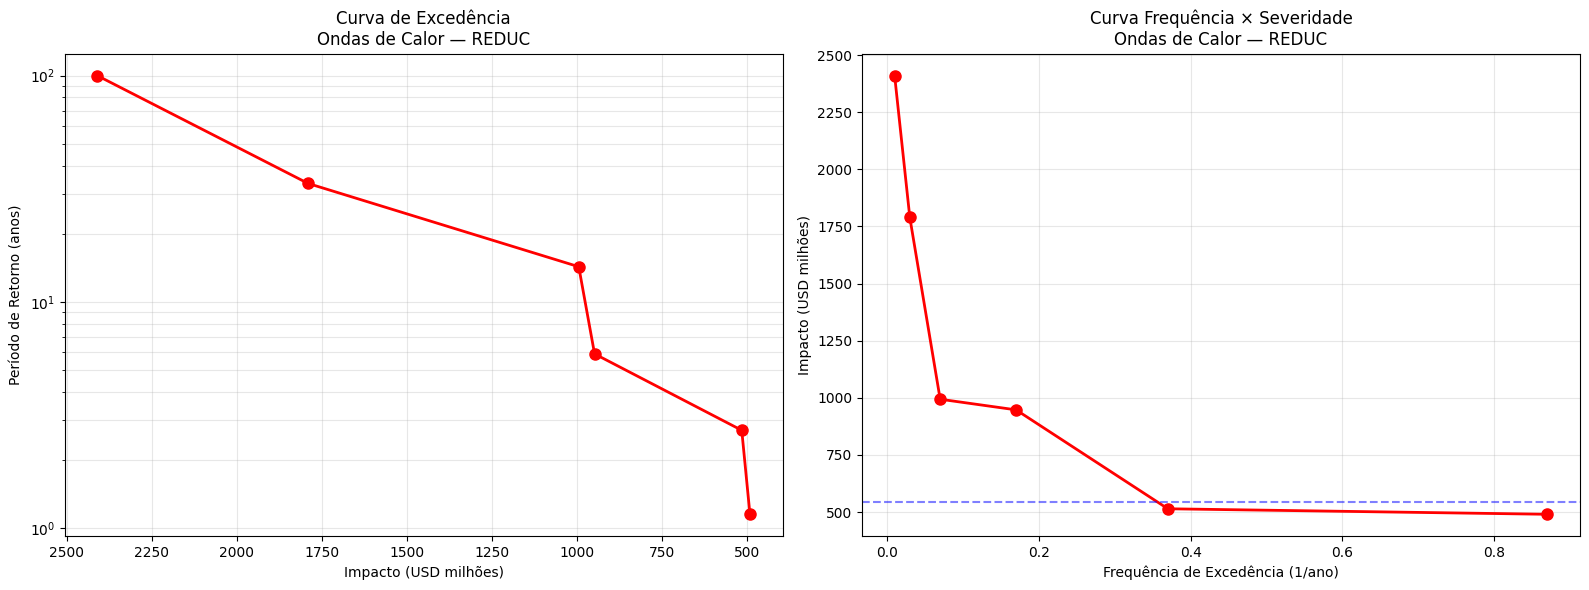

   Gráfico salvo: exceedance_curve_hw_reduc.png


In [9]:
# =============================================================================
# BLOCO 8: CURVA DE EXCED\u00caNCIA
# =============================================================================
# Mesma l\u00f3gica do NB01 \u2014 a curva de exced\u00eancia \u00e9 o artefato mais
# importante para gestores de risco e seguradoras.

print("\ud83d\udcc9 Gerando curva de exced\u00eancia...")

try:
    # Calcular curva de exced\u00eancia manualmente (m\u00e9todo compat\u00edvel com v6.1)
    sorted_indices = np.argsort(imp.at_event)[::-1]
    sorted_impacts = imp.at_event[sorted_indices]
    sorted_freq = imp.frequency[sorted_indices]
    exc_freq = np.cumsum(sorted_freq)
    return_periods_curve = 1.0 / exc_freq

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Gr\u00e1fico 1: Impacto vs Per\u00edodo de Retorno
    axes[0].semilogy(sorted_impacts / 1e6, return_periods_curve, 'ro-',
                     markersize=8, linewidth=2)
    axes[0].set_xlabel('Impacto (USD milh\u00f5es)')
    axes[0].set_ylabel('Per\u00edodo de Retorno (anos)')
    axes[0].set_title('Curva de Exced\u00eancia\nOndas de Calor \u2014 REDUC')
    axes[0].grid(True, alpha=0.3, which='both')
    axes[0].invert_xaxis()

    # Gr\u00e1fico 2: Impacto vs Probabilidade de Exced\u00eancia
    axes[1].plot(exc_freq, sorted_impacts / 1e6, 'ro-',
                 markersize=8, linewidth=2)
    axes[1].set_xlabel('Frequ\u00eancia de Exced\u00eancia (1/ano)')
    axes[1].set_ylabel('Impacto (USD milh\u00f5es)')
    axes[1].set_title('Curva Frequ\u00eancia \u00d7 Severidade\nOndas de Calor \u2014 REDUC')
    axes[1].grid(True, alpha=0.3)

    # Anotar EAI
    for ax in axes:
        ax.axhline(y=imp.aai_agg/1e6 if ax == axes[1] else 0,
                   color='blue', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.savefig('exceedance_curve_hw_reduc.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("   Gr\u00e1fico salvo: exceedance_curve_hw_reduc.png")

except Exception as e:
    print(f"   \u26a0\ufe0f Curva de exced\u00eancia n\u00e3o dispon\u00edvel: {e}")

In [10]:
# =============================================================================
# BLOCO 9: RESUMO EXECUTIVO + LIMITA\u00c7\u00d5ES
# =============================================================================

print("="*70)
print("  CLIMARISK-OG \u2014 NOTEBOOK 02: ONDAS DE CALOR")
print("  Resumo Executivo")
print("="*70)
print(f"""
  ATIVO: {REDUC_NAME}
  COORDENADAS: ({REDUC_LAT}, {REDUC_LON})
  VALOR DE EXPOSI\u00c7\u00c3O: USD {REDUC_VALUE_USD:,.0f}

  HAZARD: Ondas de Calor (Heat Wave)
  INTENSIDADE: \u00b0C acima de {T_THRESHOLD_C}\u00b0C (limiar operacional)
  EVENTOS: {n_events} (per\u00edodos de retorno: 2 a 100 anos)
  \u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500

  RESULTADOS:
  EAI (Expected Annual Impact):  USD     {imp.aai_agg:>15,.0f}
  Raz\u00e3o EAI/Valor do Ativo:             {(imp.eai_exp[0] / REDUC_VALUE_USD) * 100:.4f}%
  \u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500

  PERDAS POR PER\u00cdODO DE RETORNO:""")

for i, evt in enumerate(events):
    bar_len = int((imp.at_event[i] / REDUC_VALUE_USD) * 60)
    bar = '\u2588' * max(1, bar_len)
    print(f"    RP {evt['rp']:>3d}a (\u0394T={evt['delta_t']:.1f}\u00b0C): "
          f"USD {imp.at_event[i]:>13,.0f}  {bar}")

print(f"""\n  \u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500

  COMPARA\u00c7\u00c3O COM NB01 (Inunda\u00e7\u00e3o):
    O EAI de ondas de calor \u00e9 tipicamente MENOR que o de inunda\u00e7\u00e3o
    para refinarias, porque o dano \u00e9 predominantemente operacional
    (perda de throughput) e n\u00e3o f\u00edsico-destrutivo.
    A compara\u00e7\u00e3o formal ser\u00e1 feita no NB03 (multi-hazard).

  METODOLOGIA:
    Framework: CLIMADA v{ver} (ETH Z\u00fcrich)
    Hazard:    Onda de calor (\u00b0C acima de limiar operacional)
    Exposure:  Ponto georreferenciado com valor de reposi\u00e7\u00e3o
    Impact Fn: Customizada \u2014 Industrial Facility (Refinery)
    Refer\u00eancias: ECA/McKinsey (2009); Kjellstrom et al. (2016);
               ILO (2019); McEvoy et al. (2012)

  LIMITA\u00c7\u00d5ES (documenta\u00e7\u00e3o obrigat\u00f3ria TRL5):
    1. Dados de hazard s\u00e3o sint\u00e9ticos calibrados \u2014 n\u00e3o s\u00e3o rean\u00e1lise ERA5.
       Em produ\u00e7\u00e3o, usar ERA5 2m-temperature ou proje\u00e7\u00f5es CMIP6/CORDEX.
    2. Valor de exposi\u00e7\u00e3o \u00e9 estimativa p\u00fablica \u2014 em produ\u00e7\u00e3o, usar
       dados reais de valor de reposi\u00e7\u00e3o fornecidos pela Petrobras.
    3. Fun\u00e7\u00e3o de dano \u00e9 customizada baseada em literatura \u2014 n\u00e3o
       calibrada com dados hist\u00f3ricos reais de perdas operacionais.
       Em produ\u00e7\u00e3o, calibrar com dados de paradas operacionais da REDUC.
    4. Limiar operacional de 40\u00b0C \u00e9 gen\u00e9rico \u2014 cada unidade de
       processo tem limiares espec\u00edficos (FCC, destila\u00e7\u00e3o, etc.).
    5. Efeitos de dura\u00e7\u00e3o da onda n\u00e3o modelados separadamente \u2014
       intensidade \u00e9 proxy para severidade+dura\u00e7\u00e3o combinadas.
    6. Cen\u00e1rio baseline apenas \u2014 falta proje\u00e7\u00f5es futuras.
    7. Ativo \u00fanico \u2014 em produ\u00e7\u00e3o, expandir para portf\u00f3lio.

======================================================================
  FIM DO NOTEBOOK 02 \u2014 Vers\u00e3o 1.0 \u2014 Mar\u00e7o 2026
======================================================================""")

  CLIMARISK-OG — NOTEBOOK 02: ONDAS DE CALOR
  Resumo Executivo
  
  ATIVO: REDUC - Refinaria Duque de Caxias
  COORDENADAS: (-22.53, -43.28)
  VALOR DE EXPOSIÇÃO: USD 5,000,000,000

  HAZARD: Ondas de Calor (Heat Wave)
  INTENSIDADE: °C acima de 40.0°C (limiar operacional)
  EVENTOS: 6 (períodos de retorno: 2 a 100 anos)
  ─────────────────────────────────────────────────

  RESULTADOS:
  EAI (Expected Annual Impact):  USD         542,466,740
  Razão EAI/Valor do Ativo:             10.8493%
  ─────────────────────────────────────────────────

  PERDAS POR PERÍODO DE RETORNO:
    RP   2a (ΔT=1.0°C): USD   490,358,357  █████
    RP   5a (ΔT=2.0°C): USD   514,487,769  ██████
    RP  10a (ΔT=3.0°C): USD   947,378,686  ███████████
    RP  25a (ΔT=4.5°C): USD   993,896,656  ███████████
    RP  50a (ΔT=6.0°C): USD 1,789,664,757  █████████████████████
    RP 100a (ΔT=8.0°C): USD 2,410,297,713  ████████████████████████████

  ─────────────────────────────────────────────────

  COMPARAÇÃO COM 

In [11]:
# =============================================================================
# BLOCO 10: EXPORTAR RESULTADOS EM JSON (SCHEMA COMPAT\u00cdVEL COM NB01)
# =============================================================================
# O JSON segue EXATAMENTE o mesmo schema do NB01, mudando apenas
# os campos hazard-specific. Isso permite que o backend (Railway)
# consuma qualquer notebook com o mesmo parser.

import json

results = {
    'metadata': {
        'notebook': 'nb02_heatwave_duque_caxias',
        'version': '1.0',
        'date': datetime.now().isoformat(),
        'climada_version': ver,
        'methodology': 'CLIMADA H\u00d7E\u00d7V probabilistic impact',
    },
    'asset': {
        'name': REDUC_NAME,
        'lat': REDUC_LAT,
        'lon': REDUC_LON,
        'value_usd': REDUC_VALUE_USD,
    },
    'hazard': {
        'type': 'HW',
        'type_name': 'Heat Wave',
        'n_events': n_events,
        'return_periods': [e['rp'] for e in events],
        'max_intensity': float(haz_hw.intensity.max()),
        'intensity_unit': '\u00b0C above threshold',
        'threshold_c': T_THRESHOLD_C,
    },
    'impact_function': {
        'name': 'Heat Wave \u2014 Industrial Facility (Refinery)',
        'source': 'Custom \u2014 based on ECA/McKinsey (2009), Kjellstrom et al. (2016), ILO (2019)',
        'type': 'operational_loss',
        'note': 'Predominantly throughput loss, not physical destruction',
    },
    'results': {
        'eai_usd': float(imp.aai_agg),
        'eai_ratio_pct': float((imp.eai_exp[0] / REDUC_VALUE_USD) * 100),
        'impact_by_return_period': {
            str(evt['rp']): float(imp.at_event[i])
            for i, evt in enumerate(events)
        },
    },
    'limitations': [
        'Dados de hazard sint\u00e9ticos \u2014 n\u00e3o rean\u00e1lise ERA5',
        'Valor de exposi\u00e7\u00e3o estimado \u2014 usar dados Petrobras em produ\u00e7\u00e3o',
        'Fun\u00e7\u00e3o de dano customizada \u2014 n\u00e3o calibrada com dados reais',
        'Limiar de 40\u00b0C gen\u00e9rico \u2014 calibrar por unidade de processo',
        'Dura\u00e7\u00e3o da onda n\u00e3o modelada separadamente',
        'Cen\u00e1rio baseline apenas \u2014 falta proje\u00e7\u00f5es clim\u00e1ticas futuras',
        'Ativo \u00fanico \u2014 expandir para 45 ativos em produ\u00e7\u00e3o',
    ]
}

with open('results_nb02_heatwave_reduc.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, indent=2, ensure_ascii=False)

print("\n\ud83d\udcbe Resultados exportados: results_nb02_heatwave_reduc.json")
print("   (schema compat\u00edvel com NB01 \u2014 mesmo parser no backend)")

# Mostrar conte\u00fado
print("\n\ud83d\udcc4 Conte\u00fado do JSON:")
print(json.dumps(results, indent=2, ensure_ascii=False))

ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 104, in json_packer
    ).encode("utf8", errors="surrogateescape")
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 30-31: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/zmq/eventloop/zmqstream.py", line 551, in _run_callback
    f = callback(*args, **kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py", line 120, in _handle_event
    event_f()
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py", line 518, in _flush
    self.session.send(
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 848, in send
    to_s

  PARTE 1: ARTEFATOS GERADOS — NOTEBOOK 02 (Ondas de Calor)
  ✅ exp_reduc_hw.png (87.8 KB)


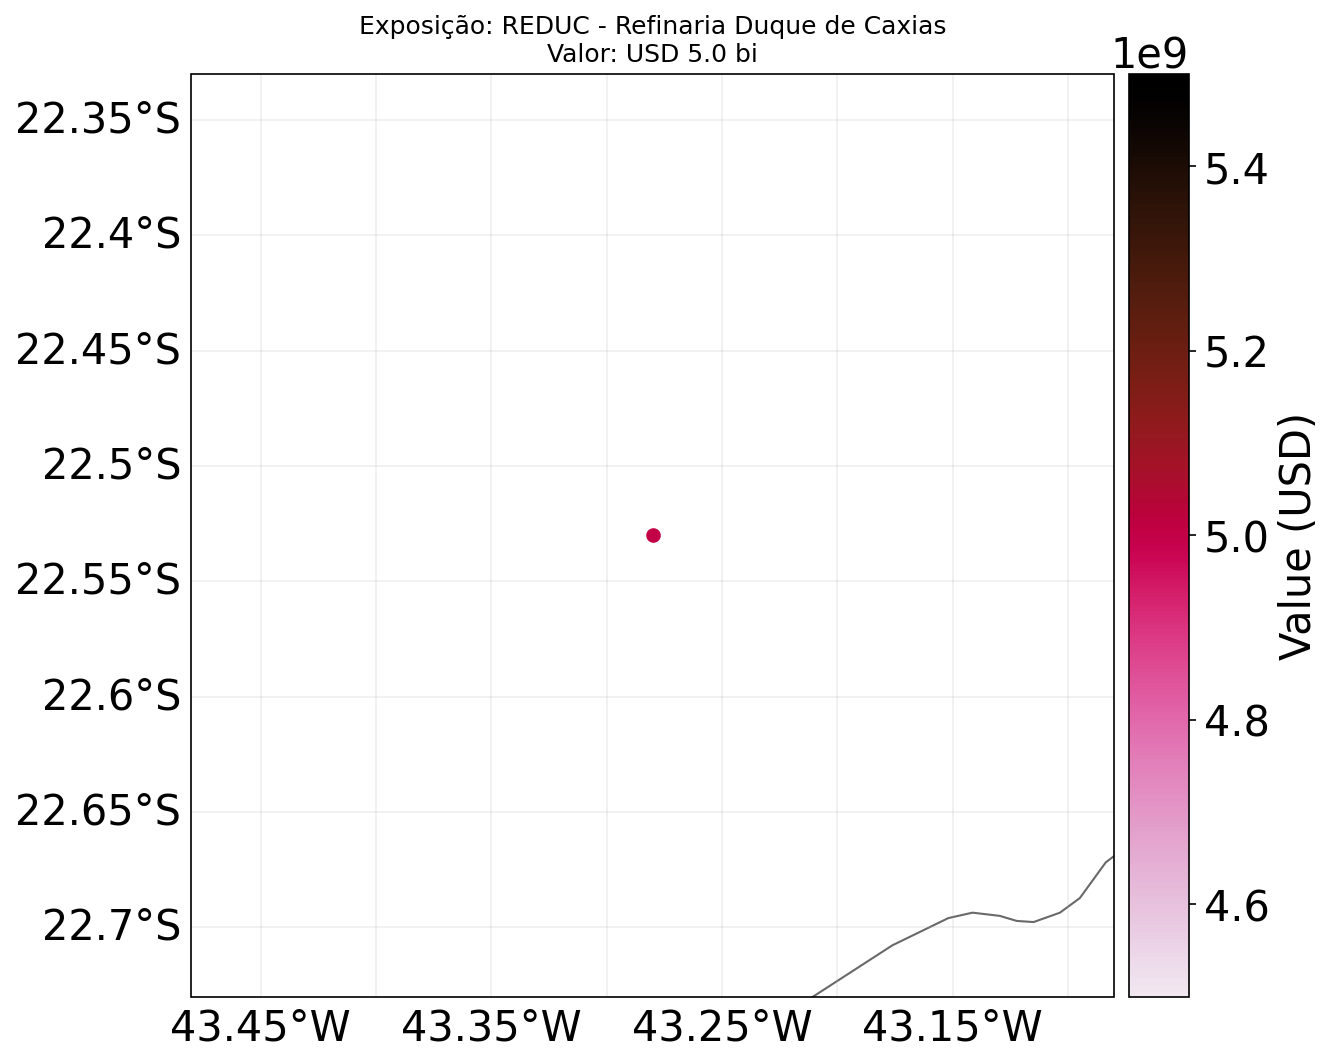

  ✅ haz_hw_rp10.png (227.1 KB)


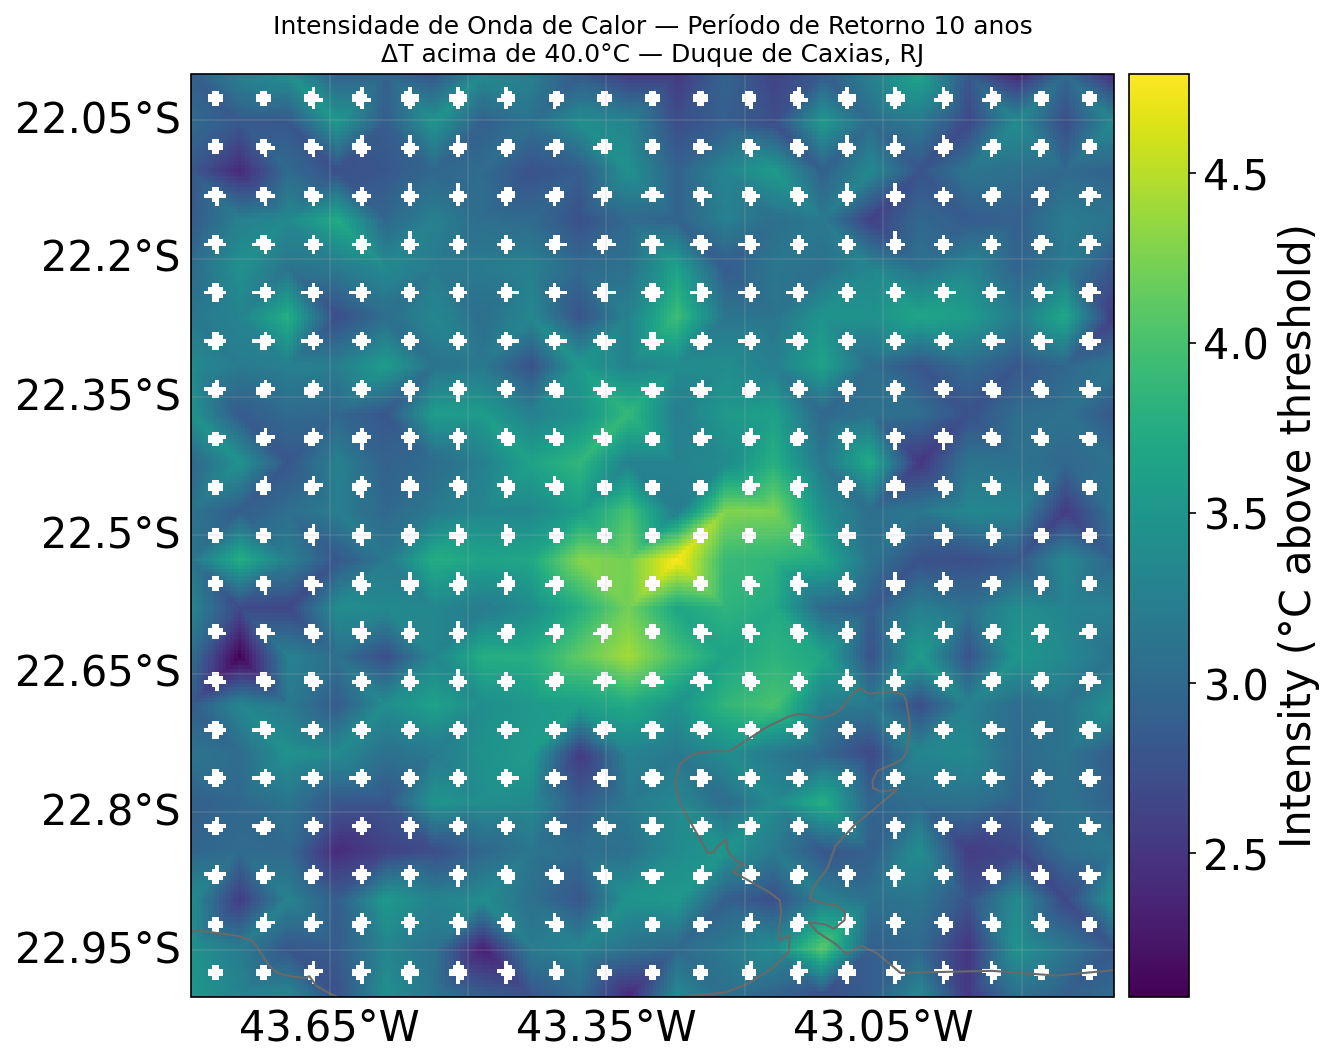

  ✅ haz_hw_return_periods.png (393.2 KB)


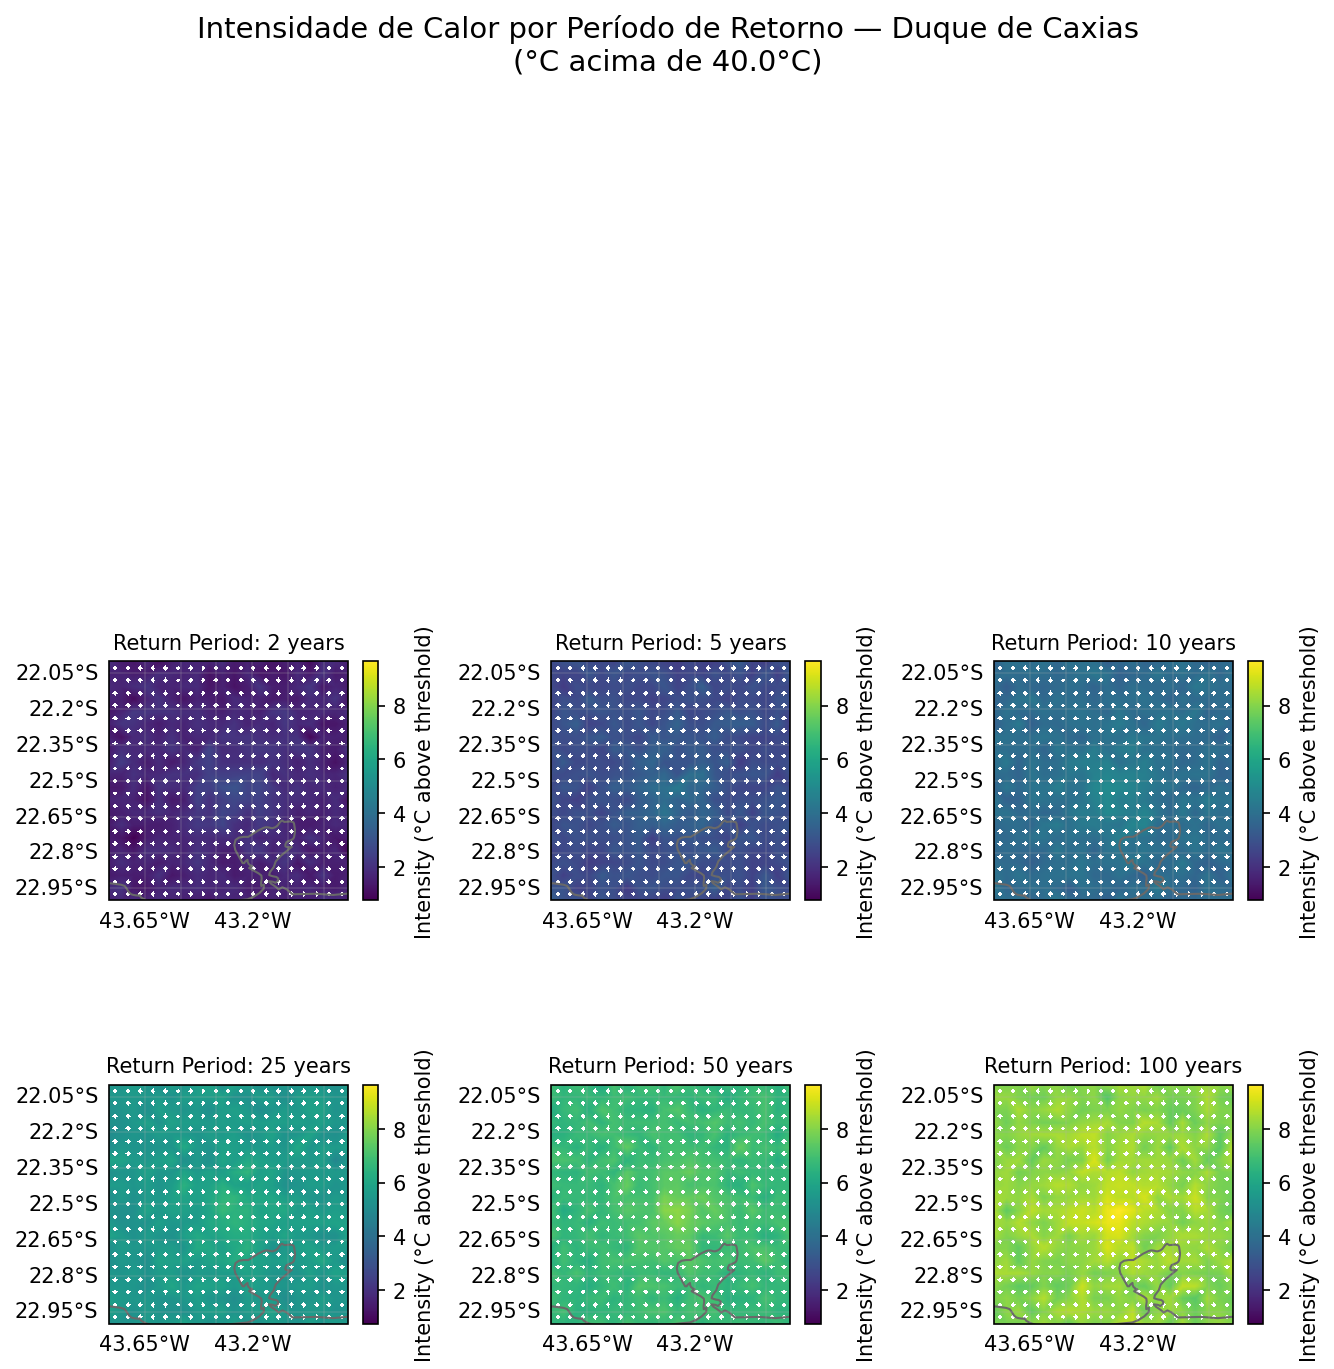

  ✅ impf_heatwave_industrial.png (79.6 KB)


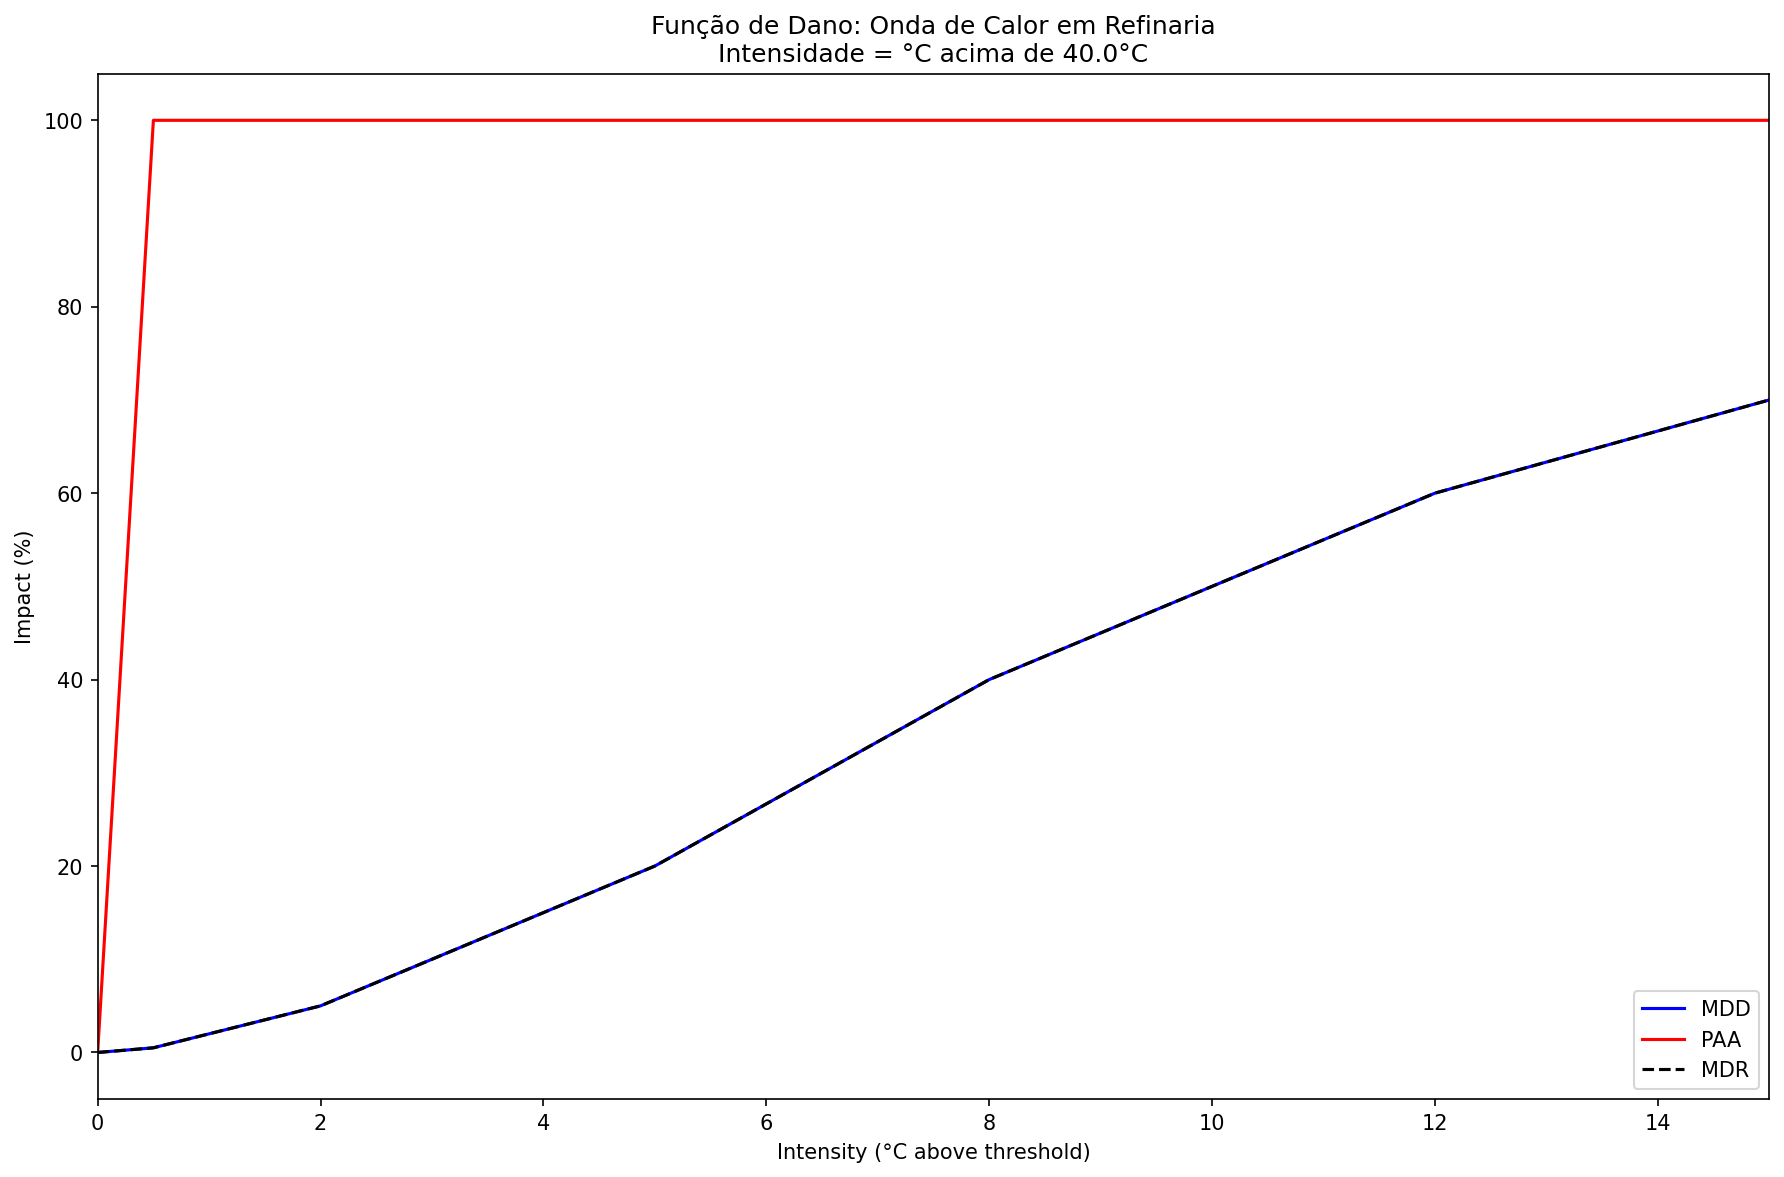

  ✅ impact_results_hw_reduc.png (102.3 KB)


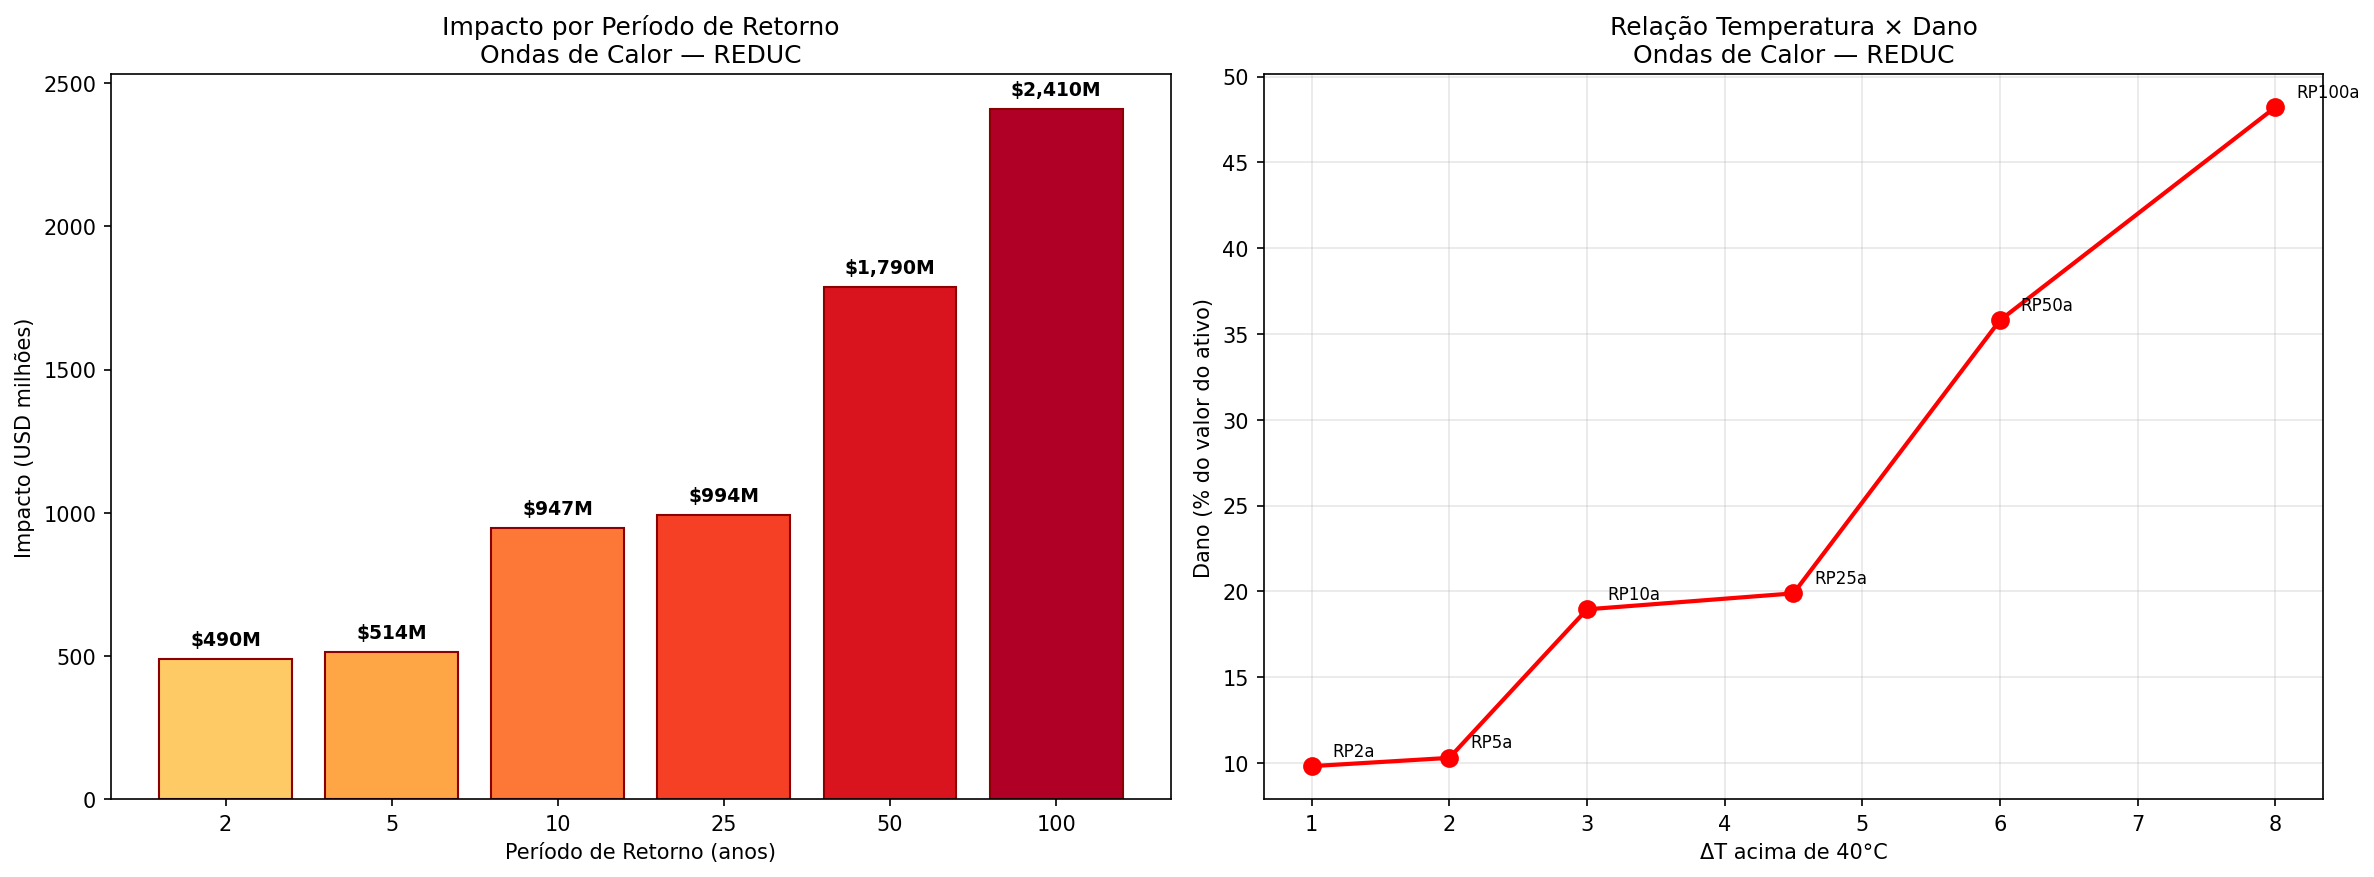

  ✅ exceedance_curve_hw_reduc.png (106.7 KB)


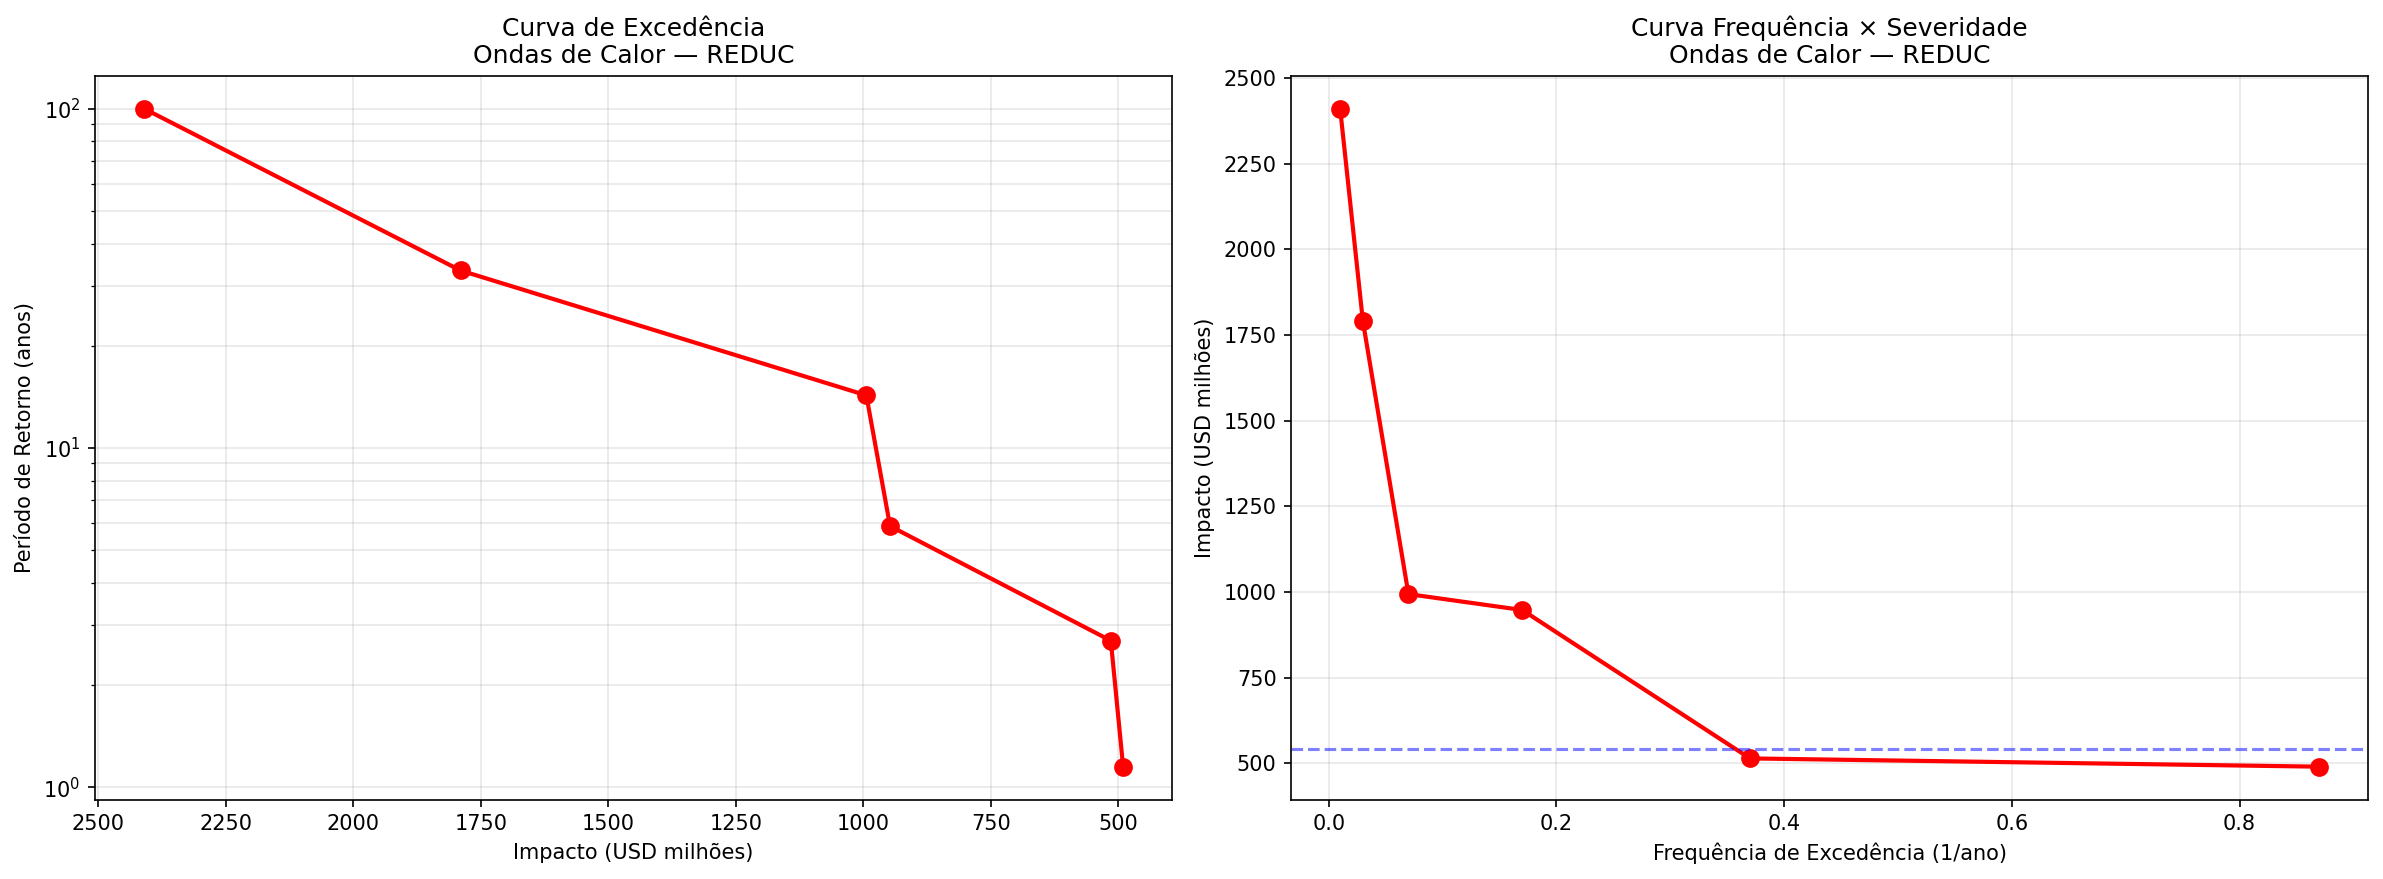

ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 104, in json_packer
    ).encode("utf8", errors="surrogateescape")
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 77-78: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/zmq/eventloop/zmqstream.py", line 551, in _run_callback
    f = callback(*args, **kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py", line 120, in _handle_event
    event_f()
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py", line 518, in _flush
    self.session.send(
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 848, in send
    to_s

tot_value: 5,000,000,000.00
imp_mat shape: (6, 1)
imp_mat nnz: 6

Detalhamento completo por evento:
        Evento |   RP |    ΔT |     Freq |        Impacto USD |  % Valor
  ------------ | ---- | ----- | -------- | ------------------ | --------
        hw_rp2 |    2 |   1.0 |   0.5000 |     490,358,357.36 |  9.8072%
        hw_rp5 |    5 |   2.0 |   0.2000 |     514,487,768.84 | 10.2898%
       hw_rp10 |   10 |   3.0 |   0.1000 |     947,378,686.46 | 18.9476%
       hw_rp25 |   25 |   4.5 |   0.0400 |     993,896,655.58 | 19.8779%
       hw_rp50 |   50 |   6.0 |   0.0200 |   1,789,664,756.56 | 35.7933%
      hw_rp100 |  100 |   8.0 |   0.0100 |   2,410,297,712.68 | 48.2060%
               |      |       |    TOTAL |   7,146,083,937.49 |
               |      |       |      EAI |     542,466,739.58 | 10.8493%

--- 2.7 VERIFICAÇÃO DE CONSISTÊNCIA ---
  ✅ EAI > 0
  ✅ Impacto cresce monotonicamente com o período de retorno
  ✅ Nenhum impacto excede o valor do ativo
  ✅ haz_type compatível

In [14]:
# =============================================================================
# C\u00c9LULA FINAL: ARTEFATOS + RELAT\u00d3RIO DE DIAGN\u00d3STICO COMPLETO
# =============================================================================
# Esta c\u00e9lula gera DOIS relat\u00f3rios:
#   1. Lista de artefatos gerados (com visualiza\u00e7\u00e3o dos PNGs)
#   2. Relat\u00f3rio de diagn\u00f3stico COMPLETO com todos os estados internos
#
import os, sys, json, traceback
from IPython.display import display, Image
from datetime import datetime as _dt

# ---- PARTE 1: ARTEFATOS GERADOS ----
output_files = [
    'exp_reduc_hw.png',
    'haz_hw_rp10.png',
    'haz_hw_return_periods.png',
    'impf_heatwave_industrial.png',
    'impact_results_hw_reduc.png',
    'exceedance_curve_hw_reduc.png',
    'results_nb02_heatwave_reduc.json'
]

print("="*70)
print("  PARTE 1: ARTEFATOS GERADOS \u2014 NOTEBOOK 02 (Ondas de Calor)")
print("="*70)

for f in output_files:
    if os.path.exists(f):
        size = os.path.getsize(f) / 1024
        print(f"  \u2705 {f} ({size:.1f} KB)")
        if f.endswith('.png'):
            display(Image(filename=f, width=700))
    else:
        print(f"  \u274c {f} \u2014 N\u00c3O ENCONTRADO")

# Mostrar JSON final
if os.path.exists('results_nb02_heatwave_reduc.json'):
    with open('results_nb02_heatwave_reduc.json', 'r') as jf:
        print("\n\ud83d\udcc4 JSON exportado:")
        print(json.dumps(json.load(jf), indent=2, ensure_ascii=False))

# ---- PARTE 2: RELAT\u00d3RIO DE DIAGN\u00d3STICO COMPLETO ----
print("\n")
print("#"*70)
print("#  PARTE 2: RELAT\u00d3RIO DE DIAGN\u00d3STICO")
print("#"*70)

# --- 2.1 Ambiente ---
print("\n--- 2.1 AMBIENTE ---")
print(f"Data/hora da execu\u00e7\u00e3o: {_dt.now().isoformat()}")
print(f"Python: {sys.version}")
try:
    from importlib.metadata import version as _v
    print(f"CLIMADA: {_v('climada')}")
except: print("CLIMADA: [ERRO ao obter vers\u00e3o]")
try: print(f"climada_petals: {_v('climada-petals')}")
except: print("climada_petals: n\u00e3o instalado ou erro")
try: print(f"numpy: {np.__version__}")
except: pass
try: print(f"scipy: {__import__('scipy').__version__}")
except: pass
try: print(f"matplotlib: {matplotlib.__version__}")
except: pass
try: print(f"geopandas: {gpd.__version__}")
except: pass

# --- 2.2 Vari\u00e1veis do Ativo ---
print("\n--- 2.2 VARI\u00c1VEIS DO ATIVO ---")
try:
    print(f"REDUC_NAME: {REDUC_NAME}")
    print(f"REDUC_LAT: {REDUC_LAT}")
    print(f"REDUC_LON: {REDUC_LON}")
    print(f"REDUC_VALUE_USD: {REDUC_VALUE_USD:,.0f}")
    print(f"BBOX: {BBOX}")
    print(f"T_THRESHOLD_C: {T_THRESHOLD_C}")
except Exception as e:
    print(f"ERRO: {e}")

# --- 2.3 Exposures ---
print("\n--- 2.3 EXPOSURES ---")
try:
    print(f"Tipo: {type(exp)}")
    print(f"N\u00ba de ativos: {len(exp.gdf)}")
    print(f"Colunas: {list(exp.gdf.columns)}")
    print(f"value_unit: {exp.value_unit}")
    print(f"CRS: {exp.gdf.crs}")
    print(f"\nexp.gdf completo:")
    print(exp.gdf.to_string())
except Exception as e:
    print(f"ERRO: {e}")

# --- 2.4 Hazard ---
print("\n--- 2.4 HAZARD ---")
try:
    print(f"Tipo: {type(haz_hw)}")
    print(f"haz_type: {haz_hw.haz_type}")
    print(f"size (n_events): {haz_hw.size}")
    print(f"centroids.size: {haz_hw.centroids.size}")
    print(f"event_name: {haz_hw.event_name}")
    print(f"event_id: {haz_hw.event_id}")
    print(f"frequency: {haz_hw.frequency}")
    print(f"frequency_unit: {haz_hw.frequency_unit}")
    print(f"units: {haz_hw.units}")
    print(f"intensity shape: {haz_hw.intensity.shape}")
    print(f"intensity dtype: {haz_hw.intensity.dtype}")
    print(f"intensity min: {haz_hw.intensity.min():.4f}")
    print(f"intensity max: {haz_hw.intensity.max():.4f}")
    print(f"intensity nnz (non-zero): {haz_hw.intensity.nnz}")
    print(f"fraction shape: {haz_hw.fraction.shape}")
    print(f"fraction min: {haz_hw.fraction.min():.4f}")
    print(f"fraction max: {haz_hw.fraction.max():.4f}")
    # Intensidade no centroid mais pr\u00f3ximo da REDUC por evento
    dists = np.sqrt((haz_hw.centroids.lat - REDUC_LAT)**2 + (haz_hw.centroids.lon - REDUC_LON)**2)
    nearest_idx = np.argmin(dists)
    print(f"\nCentroid mais pr\u00f3ximo da REDUC: idx={nearest_idx}, "
          f"lat={haz_hw.centroids.lat[nearest_idx]:.4f}, "
          f"lon={haz_hw.centroids.lon[nearest_idx]:.4f}, "
          f"dist={dists[nearest_idx]:.4f}\u00b0")
    print(f"Intensidade nesse centroid por evento:")
    for i, evt in enumerate(events):
        int_val = haz_hw.intensity[i, nearest_idx]
        frac_val = haz_hw.fraction[i, nearest_idx]
        print(f"  {evt['name']:>12s} (RP{evt['rp']:>3d}a): "
              f"intensity={int_val:.4f}\u00b0C, fraction={frac_val:.4f}")
except Exception as e:
    print(f"ERRO: {e}")
    traceback.print_exc()

# --- 2.5 Impact Function ---
print("\n--- 2.5 IMPACT FUNCTION ---")
try:
    print(f"Tipo: {type(impf_hw)}")
    print(f"haz_type: {impf_hw.haz_type}")
    print(f"id: {impf_hw.id}")
    print(f"name: {impf_hw.name}")
    print(f"intensity_unit: {impf_hw.intensity_unit}")
    print(f"intensity: {impf_hw.intensity}")
    print(f"mdd:       {impf_hw.mdd}")
    print(f"paa:       {impf_hw.paa}")
    mdr = impf_hw.mdd * impf_hw.paa
    print(f"mdr (mdd*paa): {mdr}")
    print(f"\nImpactFuncSet conte\u00fado:")
    print(f"  Func\u00f5es: {list(impf_set.get_func().keys()) if hasattr(impf_set, 'get_func') else 'N/A'}")
    # Tentar listar via _data
    try:
        for ht in impf_set.get_hazard_types():
            for fid in impf_set.get_ids(haz_type=ht):
                f = impf_set.get_func(haz_type=ht, fun_id=fid)
                print(f"  [{ht}][{fid}] {f.name}")
    except Exception as e2:
        print(f"  (detalhe n\u00e3o dispon\u00edvel: {e2})")
except Exception as e:
    print(f"ERRO: {e}")
    traceback.print_exc()

# --- 2.6 Resultados de Impacto ---
print("\n--- 2.6 RESULTADOS DE IMPACTO ---")
try:
    print(f"Tipo: {type(imp)}")
    print(f"aai_agg (EAI total): {imp.aai_agg:,.2f}")
    print(f"eai_exp (EAI por exposure): {imp.eai_exp}")
    print(f"at_event (impacto por evento): {imp.at_event}")
    print(f"frequency: {imp.frequency}")
    print(f"unit: {imp.unit}")
    print(f"haz_type: {imp.haz_type}")
    # tot_value (pode estar depreciado)
    try:
        print(f"tot_value: {imp.tot_value:,.2f}")
    except Exception as e_tv:
        print(f"tot_value: DEPRECIADO ({e_tv})")
    # Matriz de impacto
    if imp.imp_mat is not None:
        print(f"imp_mat shape: {imp.imp_mat.shape}")
        print(f"imp_mat nnz: {imp.imp_mat.nnz}")
    else:
        print(f"imp_mat: None (save_mat=False?)")
    # Detalhamento por evento
    print(f"\nDetalhamento completo por evento:")
    print(f"  {'Evento':>12s} | {'RP':>4s} | {'\u0394T':>5s} | {'Freq':>8s} | {'Impacto USD':>18s} | {'% Valor':>8s}")
    print(f"  {'-'*12} | {'-'*4} | {'-'*5} | {'-'*8} | {'-'*18} | {'-'*8}")
    for i, evt in enumerate(events):
        pct = (imp.at_event[i] / REDUC_VALUE_USD) * 100
        print(f"  {evt['name']:>12s} | {evt['rp']:>4d} | {evt['delta_t']:>5.1f} | {imp.frequency[i]:>8.4f} | {imp.at_event[i]:>18,.2f} | {pct:>7.4f}%")
    print(f"  {'':>12s} | {'':>4s} | {'':>5s} | {'TOTAL':>8s} | {sum(imp.at_event):>18,.2f} |")
    print(f"  {'':>12s} | {'':>4s} | {'':>5s} | {'EAI':>8s} | {imp.aai_agg:>18,.2f} | {(imp.aai_agg/REDUC_VALUE_USD)*100:.4f}%")
except Exception as e:
    print(f"ERRO: {e}")
    traceback.print_exc()

# --- 2.7 Verifica\u00e7\u00e3o de Consist\u00eancia ---
print("\n--- 2.7 VERIFICA\u00c7\u00c3O DE CONSIST\u00caNCIA ---")
n_erros = 0

# Check 1: EAI > 0
if imp.aai_agg > 0:
    print("  \u2705 EAI > 0")
else:
    print("  \u274c EAI = 0 \u2014 POSS\u00cdVEL ERRO: hazard n\u00e3o est\u00e1 atingindo o ativo")
    n_erros += 1

# Check 2: Impacto cresce com RP
impactos = [imp.at_event[i] for i in range(n_events)]
monotonic = all(impactos[i] <= impactos[i+1] for i in range(len(impactos)-1))
if monotonic:
    print("  \u2705 Impacto cresce monotonicamente com o per\u00edodo de retorno")
else:
    print("  \u26a0\ufe0f Impacto N\u00c3O \u00e9 monotonicamente crescente \u2014 verificar hazard/impf")
    print(f"     Valores: {impactos}")
    n_erros += 1

# Check 3: Nenhum impacto > valor do ativo
if max(impactos) <= REDUC_VALUE_USD * 1.01:  # 1% margem por arredondamento
    print("  \u2705 Nenhum impacto excede o valor do ativo")
else:
    print(f"  \u274c Impacto m\u00e1ximo ({max(impactos):,.0f}) EXCEDE valor do ativo ({REDUC_VALUE_USD:,.0f})")
    n_erros += 1

# Check 4: haz_type compat\u00edvel entre hazard e impf
if haz_hw.haz_type == impf_hw.haz_type:
    print(f"  \u2705 haz_type compat\u00edvel: hazard={haz_hw.haz_type}, impf={impf_hw.haz_type}")
else:
    print(f"  \u274c haz_type INCOMPAT\u00cdVEL: hazard={haz_hw.haz_type}, impf={impf_hw.haz_type}")
    n_erros += 1

# Check 5: impf_HW na Exposure
if 'impf_HW' in exp.gdf.columns:
    impf_id_in_exp = exp.gdf['impf_HW'].iloc[0]
    print(f"  \u2705 impf_HW presente na Exposure, valor={impf_id_in_exp}")
    if impf_id_in_exp == impf_hw.id:
        print(f"  \u2705 ID corresponde \u00e0 Impact Function (id={impf_hw.id})")
    else:
        print(f"  \u274c ID N\u00c3O corresponde: exp tem {impf_id_in_exp}, impf tem {impf_hw.id}")
        n_erros += 1
else:
    print("  \u274c Coluna impf_HW N\u00c3O encontrada na Exposure")
    print(f"     Colunas dispon\u00edveis: {list(exp.gdf.columns)}")
    n_erros += 1

# Check 6: Arquivos de output existem
missing = [f for f in output_files if not os.path.exists(f)]
if not missing:
    print(f"  \u2705 Todos os {len(output_files)} arquivos de output gerados")
else:
    print(f"  \u274c {len(missing)} arquivo(s) faltando: {missing}")
    n_erros += 1

# Check 7: EAI ratio faz sentido (< 50% para calor)
eai_ratio = (imp.aai_agg / REDUC_VALUE_USD) * 100
if eai_ratio < 50:
    print(f"  \u2705 EAI ratio ({eai_ratio:.4f}%) < 50% \u2014 plaus\u00edvel para calor")
else:
    print(f"  \u26a0\ufe0f EAI ratio ({eai_ratio:.4f}%) > 50% \u2014 possivelmente alto demais para calor")
    n_erros += 1

print(f"\n{'='*70}")
if n_erros == 0:
    print(f"  \u2705 DIAGN\u00d3STICO: TUDO OK \u2014 0 erros encontrados")
else:
    print(f"  \u26a0\ufe0f DIAGN\u00d3STICO: {n_erros} ponto(s) de aten\u00e7\u00e3o encontrado(s)")
print(f"{'='*70}")

